In [1]:
%load_ext autoreload
%autoreload 2
import threadpoolctl
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
from scanpy_helpers.annotation import AnnotationHelper
from warnings import filterwarnings

sc.set_figure_params(figsize=(5, 5))
filterwarnings("ignore", category=FutureWarning)

In [2]:
adata = sc.read_h5ad("/data/datasets/SadeFeldman_2018/h5ad_tpm/SadeFeldman_2018.h5ad")

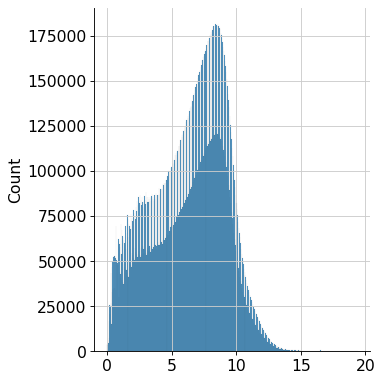

In [3]:
sns.displot(adata.X.data)

In [4]:
adata = adata[~adata.obs_names.str.contains("T_enriched"), :]

In [5]:
adata.obs["sample"] = [
    f"{patient}_{timepoint}"
    for patient, timepoint in zip(adata.obs["patient_id"], adata.obs["timepoint"])
]

Trying to set attribute `.obs` of view, copying.


In [6]:
adata.obs

cell_id                source  \
A10_P3_M11                            Sample 1  Melanoma single cell   
A11_P1_M11                            Sample 2  Melanoma single cell   
A11_P3_M11                            Sample 3  Melanoma single cell   
A11_P4_M11                            Sample 4  Melanoma single cell   
A12_P3_M11                            Sample 5  Melanoma single cell   
...                                        ...                   ...   
H5_P7_MMD7_L001_myeloid_enriched  Sample 15414  Melanoma single cell   
H6_P7_MMD7_L001_myeloid_enriched  Sample 15415  Melanoma single cell   
H7_P7_MMD7_L001_myeloid_enriched  Sample 15416  Melanoma single cell   
H8_P7_MMD7_L001_myeloid_enriched  Sample 15417  Melanoma single cell   
H9_P7_MMD7_L001_myeloid_enriched  Sample 15418  Melanoma single cell   

                                      organism patient_id   response  \
A10_P3_M11                        Homo sapiens         P1  Responder   
A11_P1_M11                        Homo sapiens         P1  Responder   
A11_P3_M11                        Homo sapiens         P1  Responder   
A11_P4_M11                        Homo sapiens         P1  Responder   
A12_P3_M11                        Homo sapiens         P1  Responder   
...                                        ...        ...        ...   
H5_P7_MMD7_L001_myeloid_enriched  Homo sapiens        P19  Responder   
H6_P7_MMD7_L001_myeloid_enriched  Homo sapiens        P19  Responder   
H7_P7_MMD7_L001_myeloid_enriched  Homo sapiens        P19  Responder   
H8_P7_MMD7_L001_myeloid_enriched  Homo sapiens        P19  Responder   
H9_P7_MMD7_L001_myeloid_enriched  Homo sapiens        P19  Responder   

                                     therapy timepoint    sample  
A10_P3_M11                        anti-CTLA4       Pre    P1_Pre  
A11_P1_M11                        anti-CTLA4       Pre    P1_Pre  
A11_P3_M11                        anti-CTLA4       Pre    P1_Pre  
A11_P4_M11                        anti-CTLA4       Pre    P1_Pre  
A12_P3_M11                        anti-CTLA4       Pre    P1_Pre  
...                                      ...       ...       ...  
H5_P7_MMD7_L001_myeloid_enriched    anti-PD1      Post  P19_Post  
H6_P7_MMD7_L001_myeloid_enriched    anti-PD1      Post  P19_Post  
H7_P7_MMD7_L001_myeloid_enriched    anti-PD1      Post  P19_Post  
H8_P7_MMD7_L001_myeloid_enriched    anti-PD1      Post  P19_Post  
H9_P7_MMD7_L001_myeloid_enriched    anti-PD1      Post  P19_Post  

[15418 rows x 8 columns]

In [7]:
sc.pp.highly_variable_genes(
    adata, flavor="cell_ranger", batch_key="sample", n_top_genes=3000
)

... storing 'sample' as categorical
/home/sturm/.conda/envs/nsclc_heterogeneity_scanpy/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
sc.tl.pca(adata)

In [9]:
sc.pp.neighbors(adata)

In [10]:
sc.tl.umap(adata)

In [11]:
sc.tl.leiden(adata)

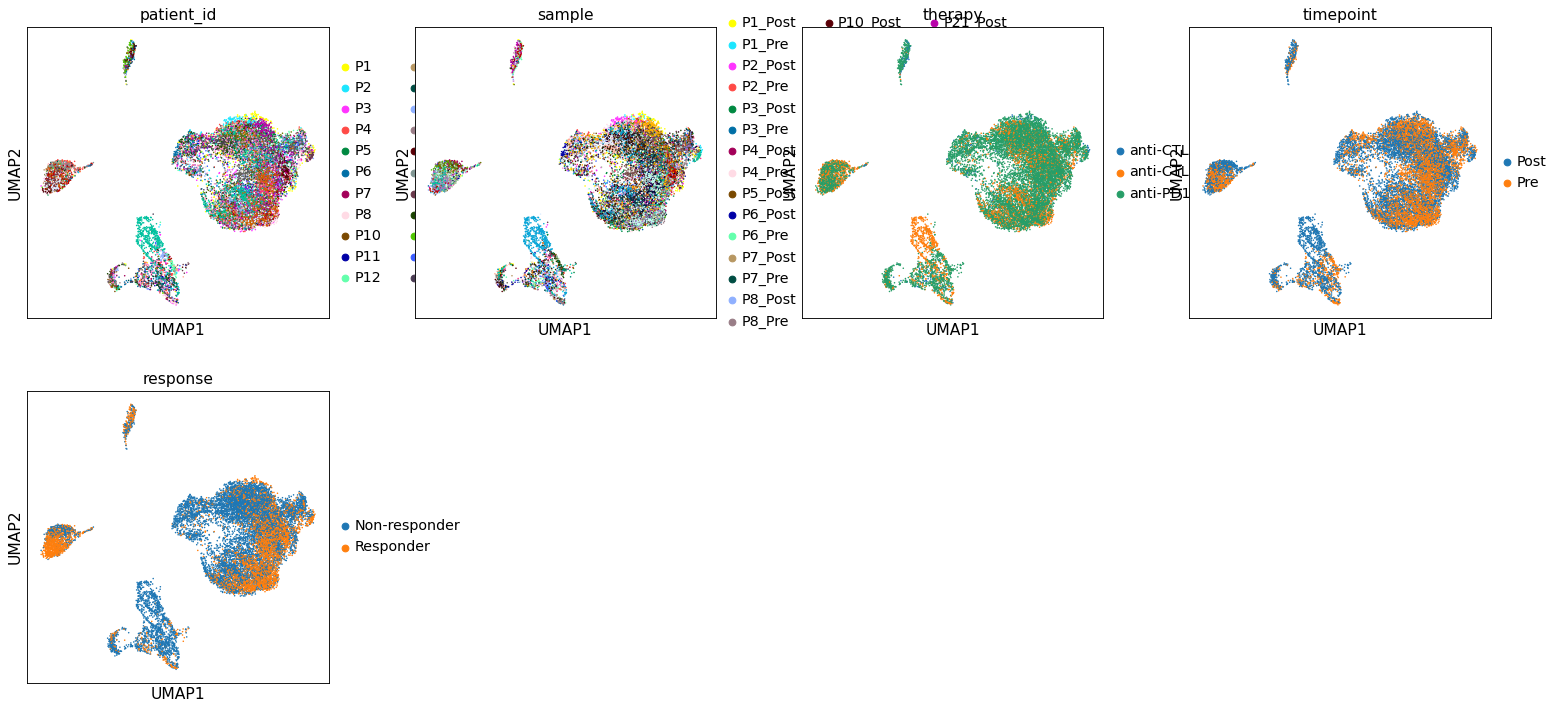

In [12]:
sc.pl.umap(adata, color=["patient_id", "sample", "therapy", "timepoint", "response"])

In [13]:
ah = AnnotationHelper()

Alevolar cell type 1


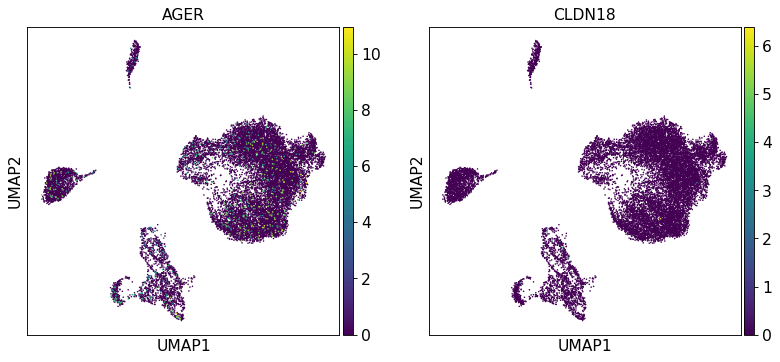

Alevolar cell type 2


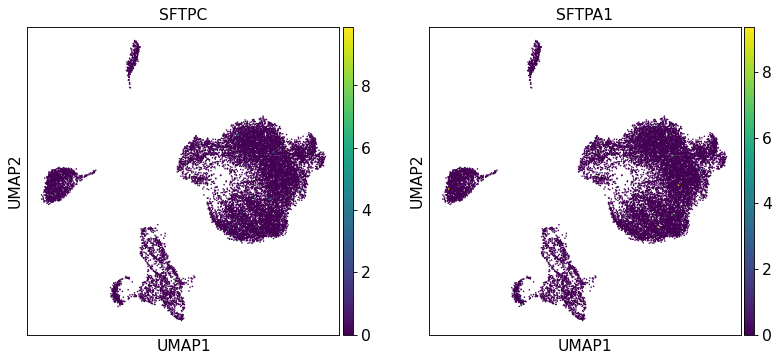

Alevolar cells (type 1 and 2)


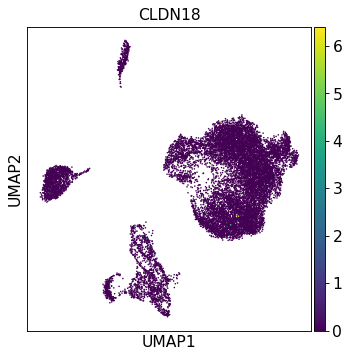

B cell


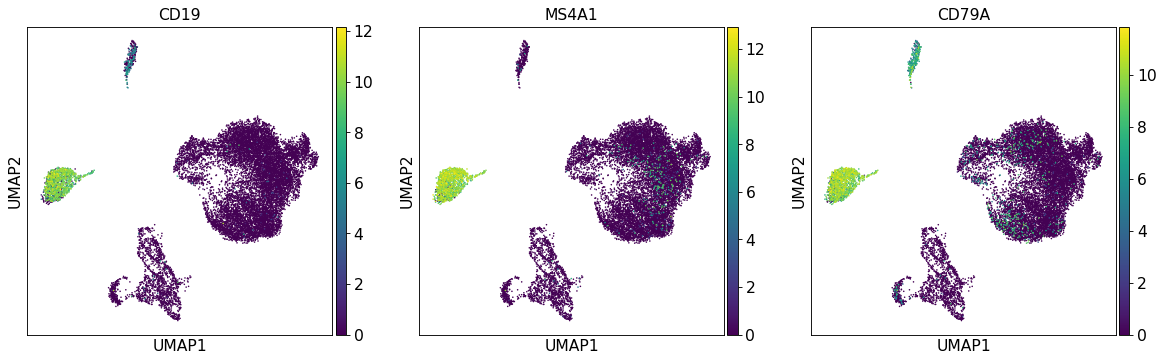

Basal


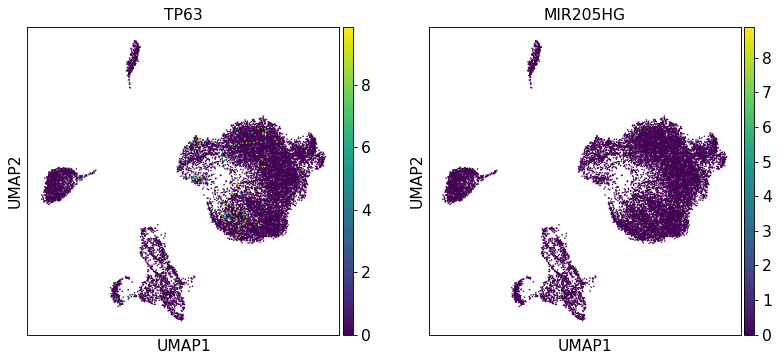

Ciliated


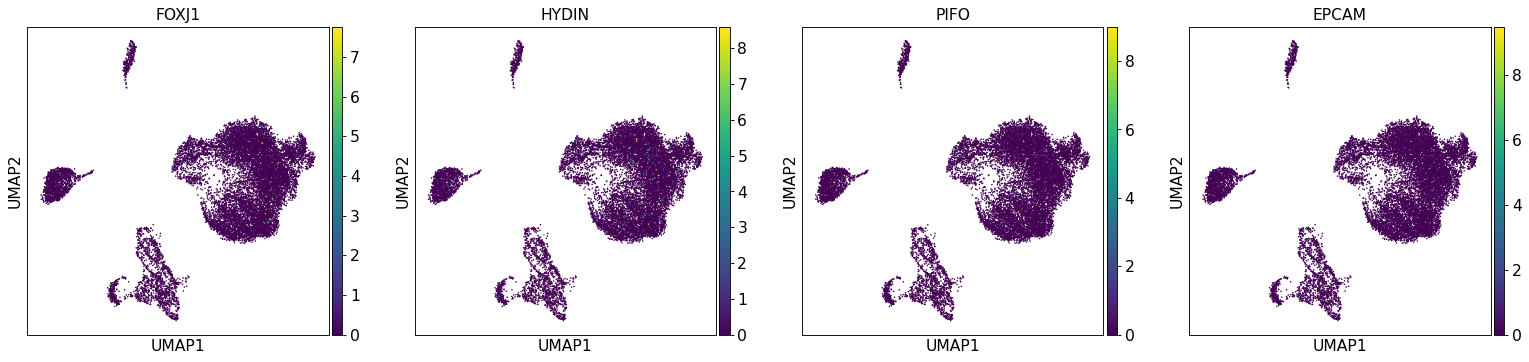

Club


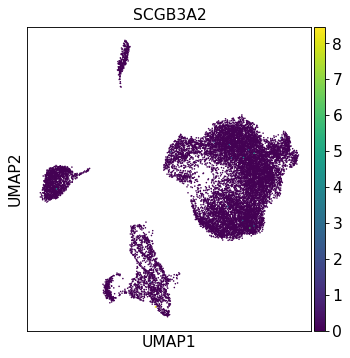

DC Lagerhans


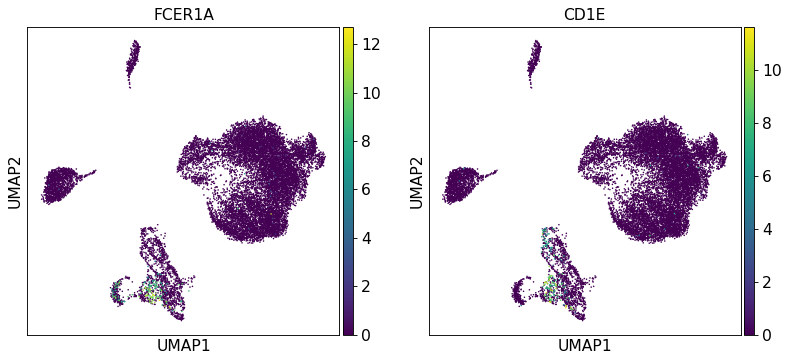

DC mature


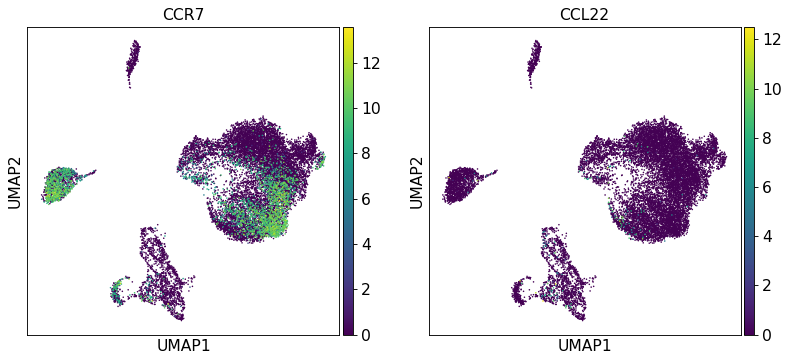

Dividing


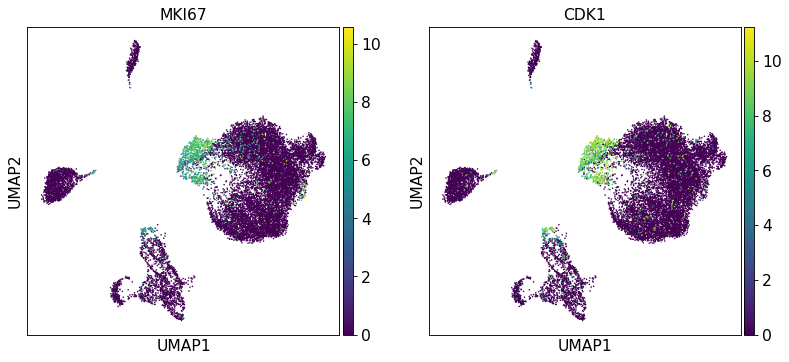

Endothelial cell


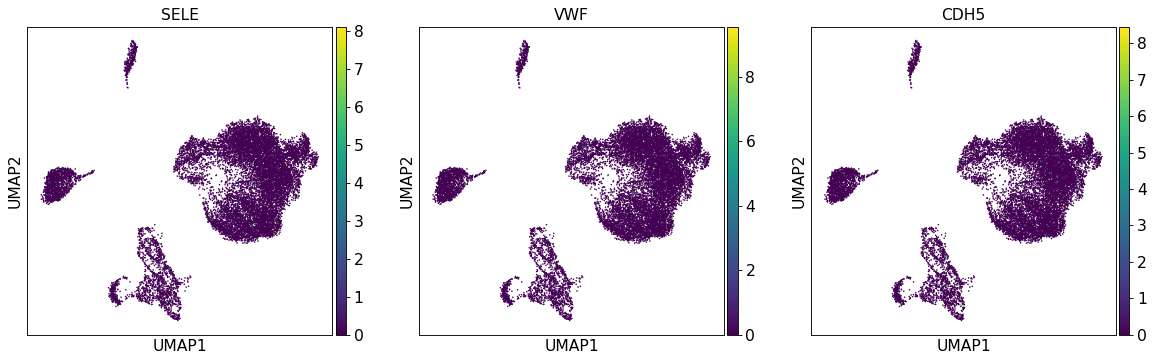

Endothelial cell lymphatic


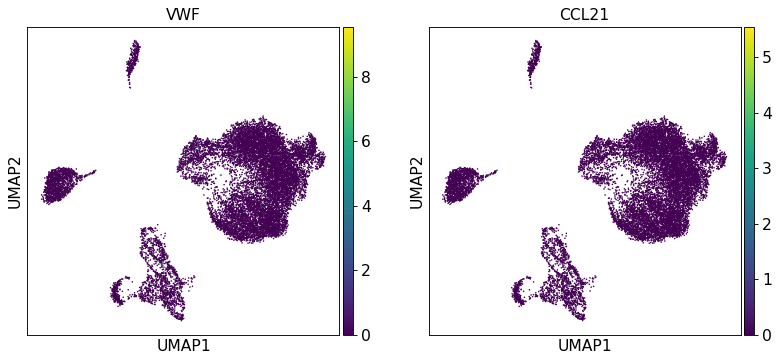

Epithelial


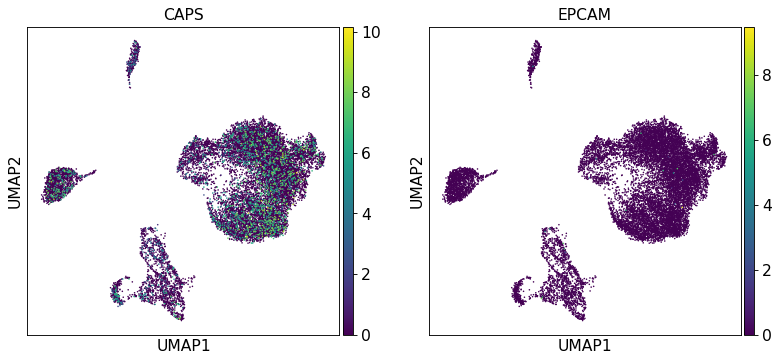

Fibroblast


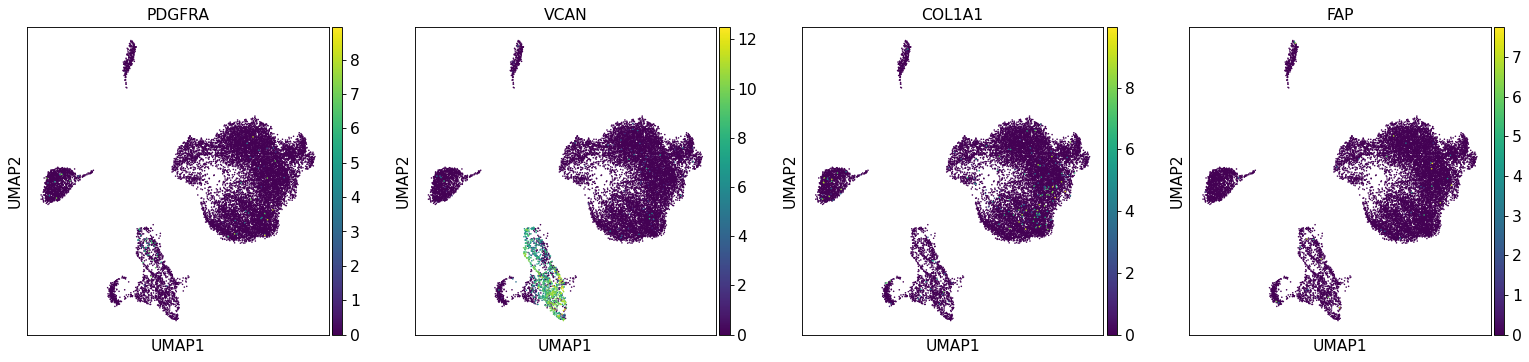

Fibroblast adventitial


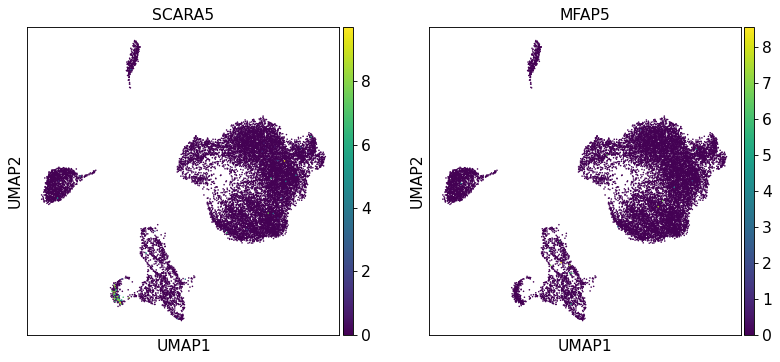

Fibroblast alveolar


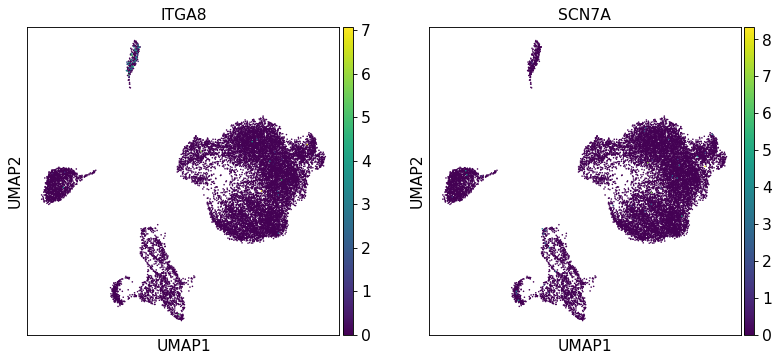

Goblet


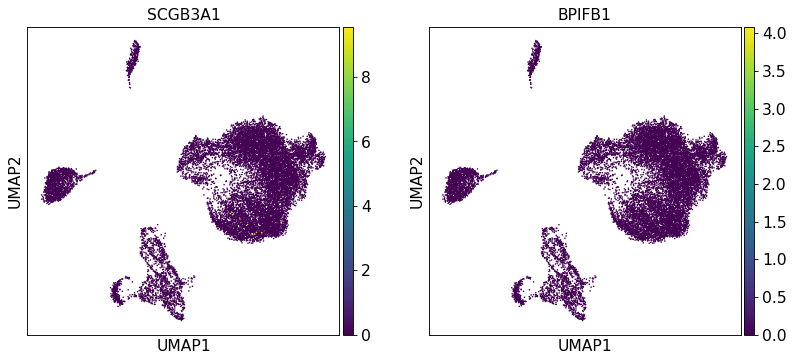

Ionocyte


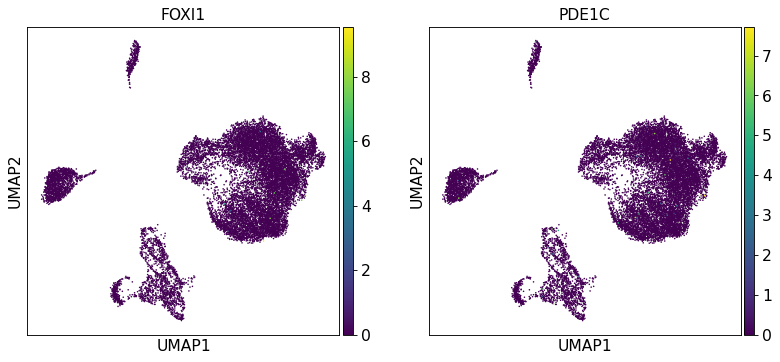

Macrophage


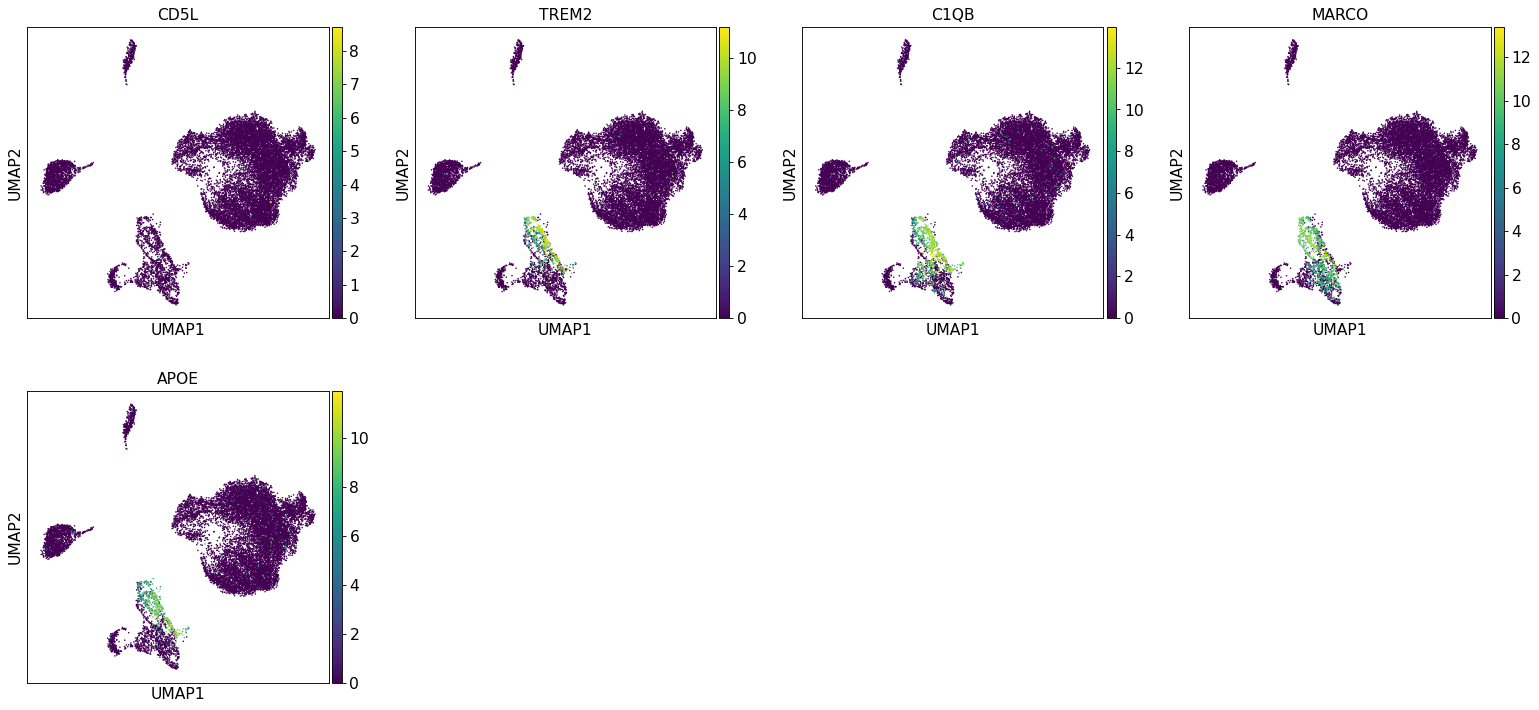

Macrophage alveolar


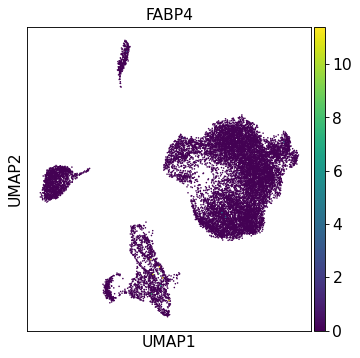

Mast cells


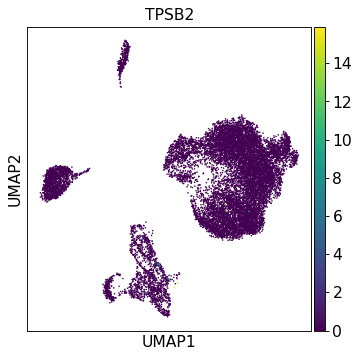

Mesothelial


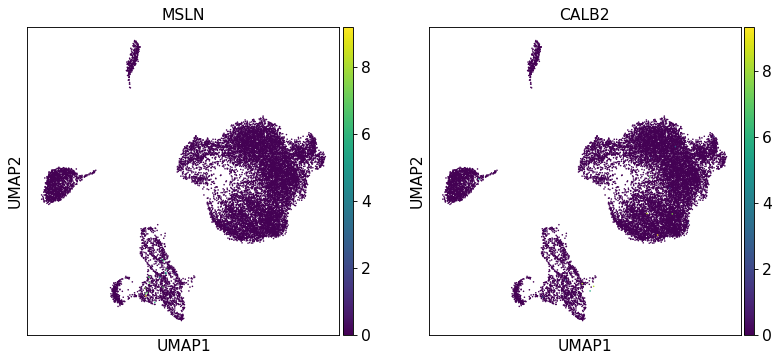

Monocyte


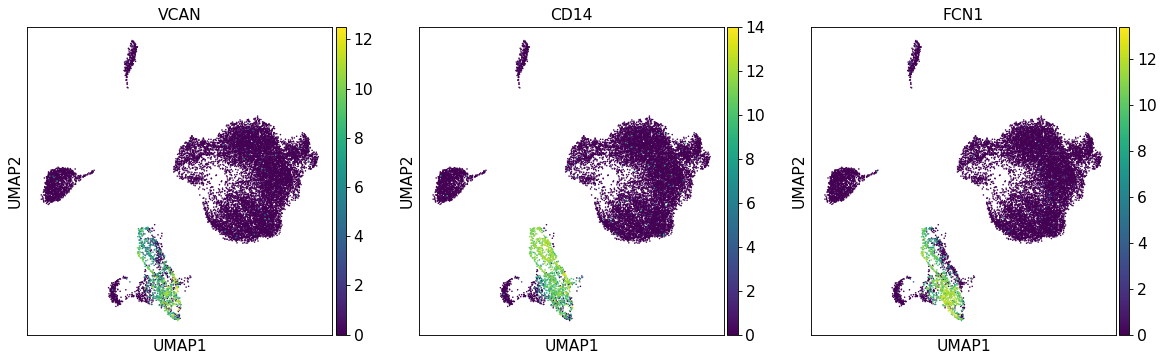

Monocyte conventional


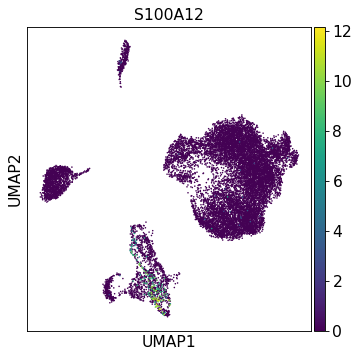

Monocyte non-coventional


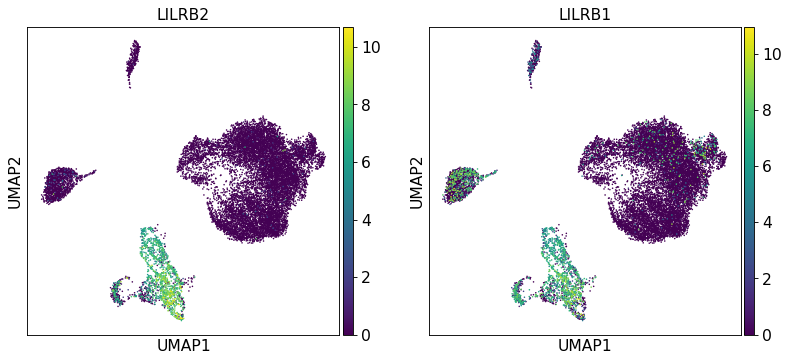

NK cell


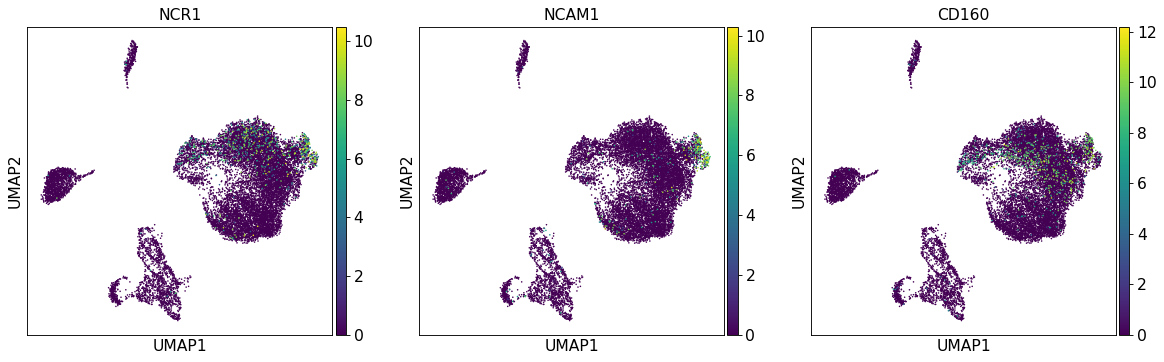

Pericyte


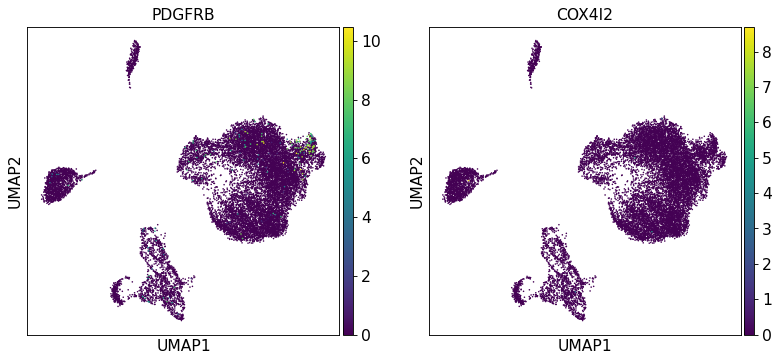

Plasma cell


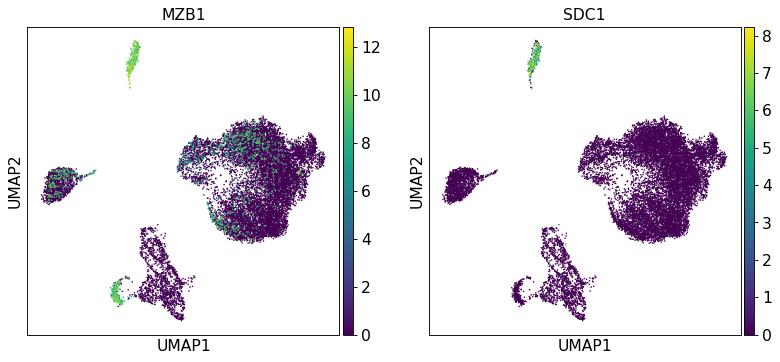

Pulmonary neuroendocrine cell


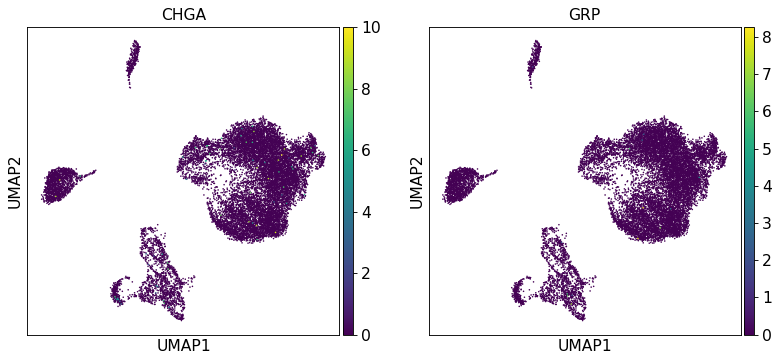

Smooth muscle cell


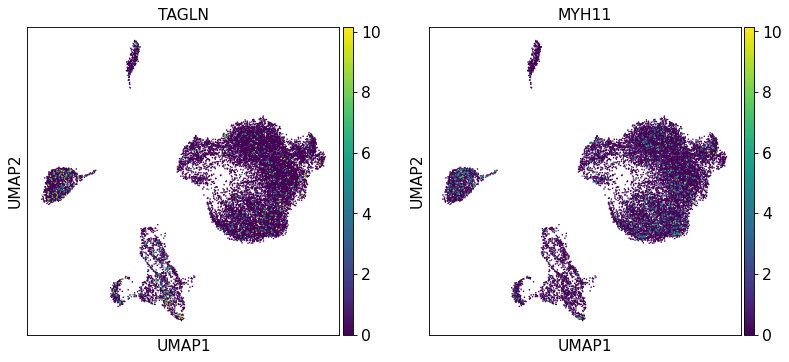

Suprabasal


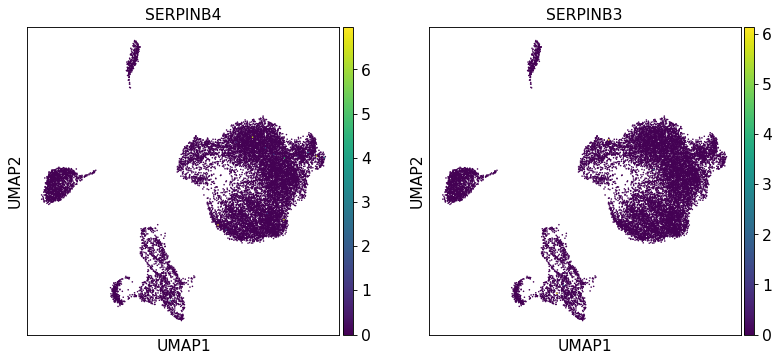

T cell


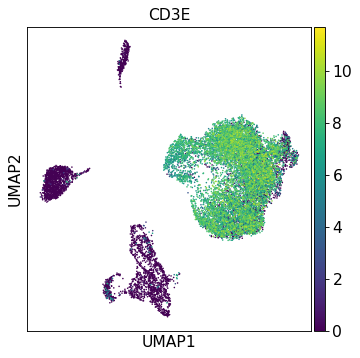

T cell CD4


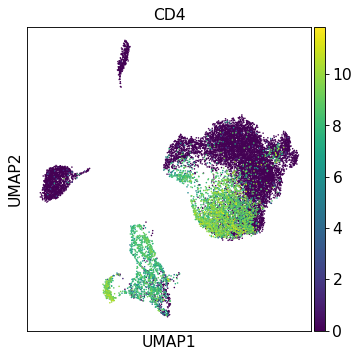

T cell CD8


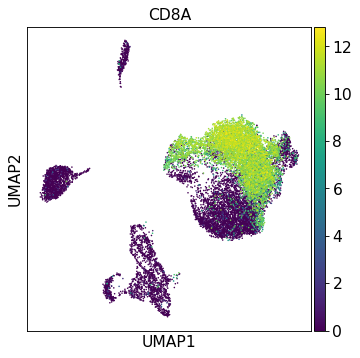

T cell cytotoxic


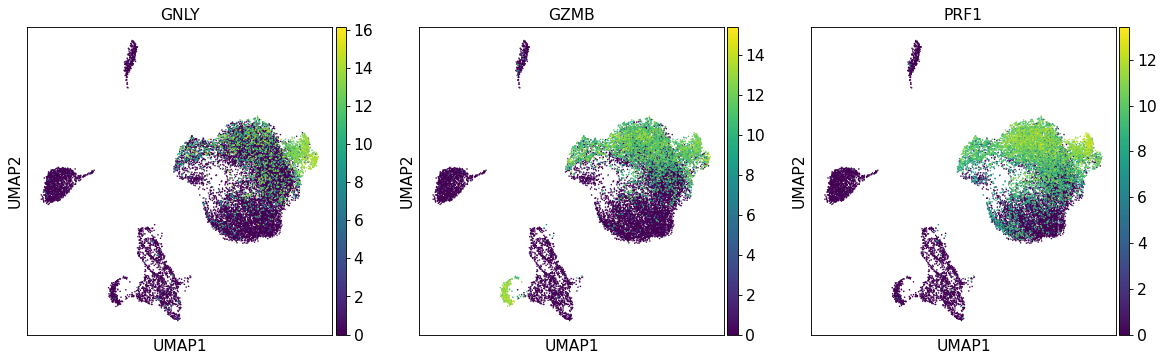

T cell regulatory


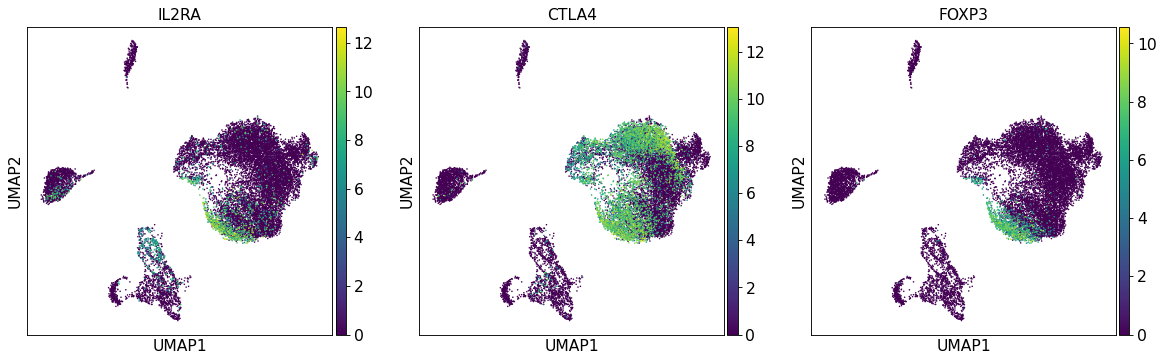

Vessel


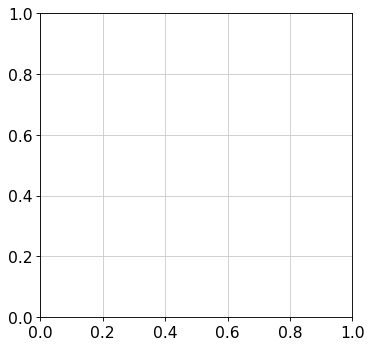

cDC1


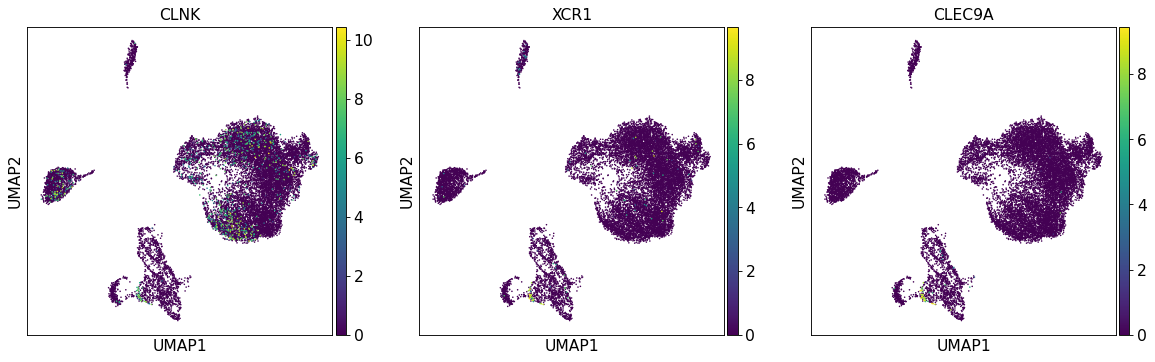

cDC2


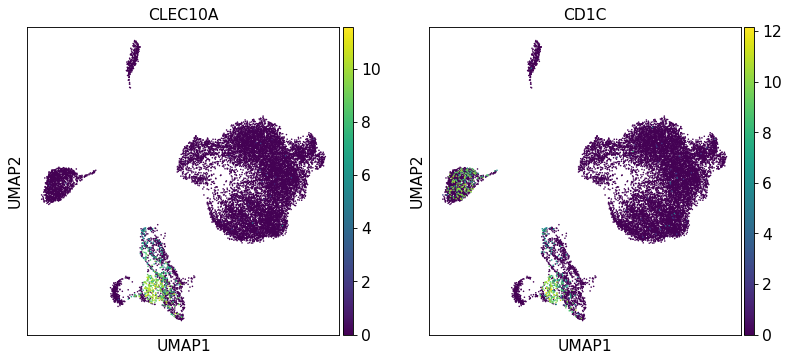

pDC


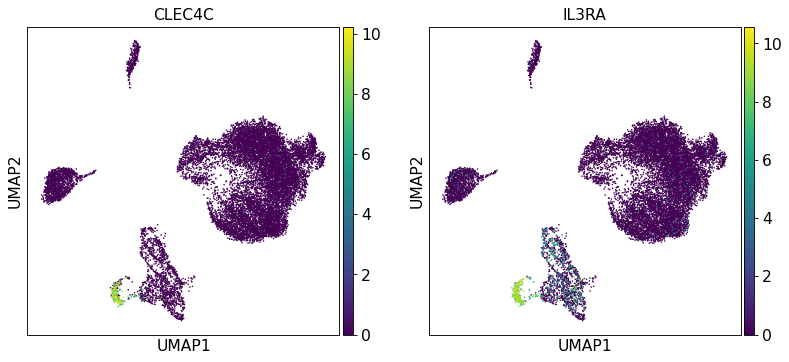

In [14]:
ah.plot_umap(adata)

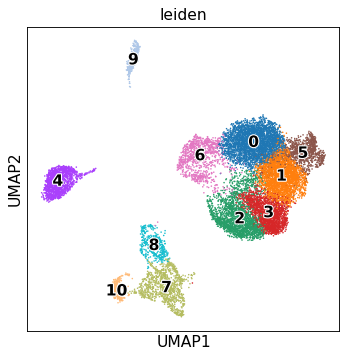

In [15]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", legend_fontoutline=2)

In [16]:
ct_map = {
    "B cell": [4],
    "Plasma cell": [9],
    "pDC": [10],
    "myeloid": [7, 8],
    "T dividing": [6],
    "T CD8": [0, 1, 5],
    "T reg": [2],
    "T CD4": [3],
}

... storing 'cell_type' as categorical


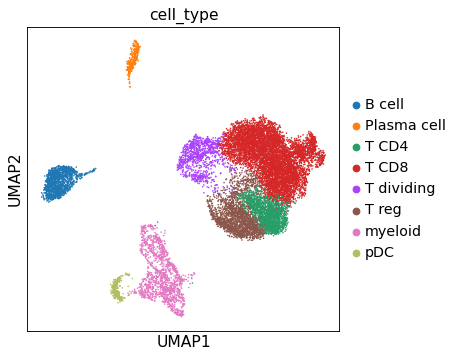

In [17]:
ah.annotate_cell_types(adata, ct_map)

In [18]:
tmp_adata = adata[
    (adata.obs["therapy"] == "anti-PD1") & (adata.obs["timepoint"] == "Pre"), :
].copy()

In [19]:
cells_per_patient = (
    tmp_adata.obs.groupby("patient_id").size().reset_index(name="cell_count")
)

In [20]:
myeloid_cells_per_patient = (
    tmp_adata.obs.loc[tmp_adata.obs["cell_type"] == "myeloid", :]
    .groupby("patient_id")
    .size()
    .reset_index(name="myeloid_cell_count")
)

In [21]:
t_cells_per_patient = (
    tmp_adata.obs.loc[tmp_adata.obs["cell_type"].str.startswith("T "), :]
    .groupby("patient_id")
    .size()
    .reset_index(name="t_cell_count")
)

In [28]:
b_cells_per_patient = (
    tmp_adata.obs.loc[tmp_adata.obs["cell_type"].str.startswith("B "), :]
    .groupby("patient_id")
    .size()
    .reset_index(name="b_cell_count")
)

In [29]:
patient_table = (
    tmp_adata.obs.loc[:, ["patient_id", "response"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .set_index("patient_id")
    .join(cells_per_patient.set_index("patient_id"))
    .join(myeloid_cells_per_patient.set_index("patient_id"))
    .join(t_cells_per_patient.set_index("patient_id"))
    .join(b_cells_per_patient.set_index("patient_id"))
)

In [31]:
patient_table["myeloid_ratio"] = (
    patient_table["myeloid_cell_count"] / patient_table["cell_count"]
)
patient_table["t_ratio"] = patient_table["t_cell_count"] / patient_table["cell_count"]
patient_table["b_ratio"] = patient_table["b_cell_count"] / patient_table["cell_count"]

<AxesSubplot:xlabel='myeloid_ratio', ylabel='t_ratio'>

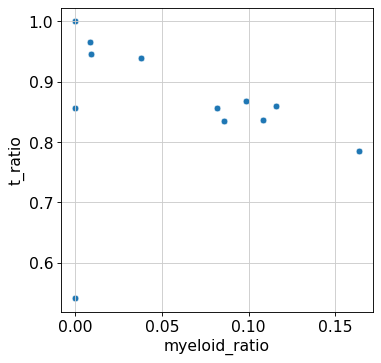

In [24]:
sns.scatterplot(data=patient_table, x="myeloid_ratio", y="t_ratio")

Text(0, 0.5, 'ratio myeloid/total cells')

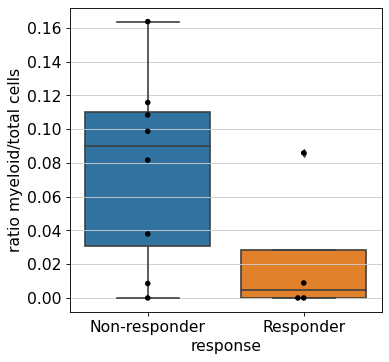

In [26]:
sns.boxplot(data=patient_table, y="myeloid_ratio", x="response")
ax = sns.swarmplot(data=patient_table, y="myeloid_ratio", x="response", color="black")
ax.set_ylabel("ratio myeloid/total cells")

Text(0, 0.5, 'ratio T/total cells')

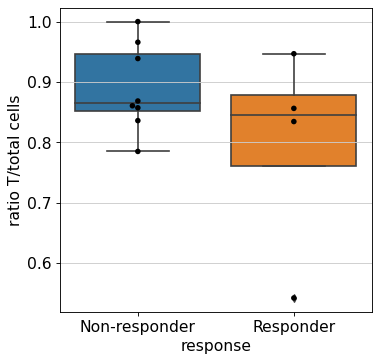

In [27]:
sns.boxplot(data=patient_table, y="t_ratio", x="response")
ax = sns.swarmplot(data=patient_table, y="t_ratio", x="response", color="black")
ax.set_ylabel("ratio T/total cells")

Text(0, 0.5, 'ratio B/total cells')

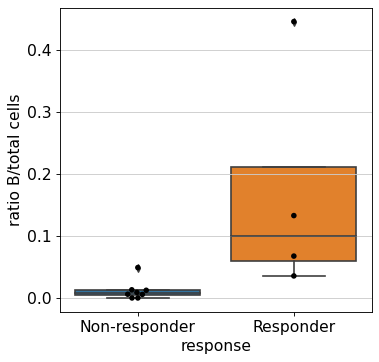

In [32]:
sns.boxplot(data=patient_table, y="b_ratio", x="response")
ax = sns.swarmplot(data=patient_table, y="b_ratio", x="response", color="black")
ax.set_ylabel("ratio B/total cells")